In [3]:
from graphviz import Digraph

def trace(root):
    nodes = set()
    edges = set()
    def build(v):
        if v in nodes:return
        nodes.add(v)
        for cv in v.prev:
            edges.add((cv, v))
            build(cv)
    build(root)
    return nodes, edges

def draw(root, format = "svg", rankdir="LR"):

    assert rankdir in ["LR", "TB"]
    g = Digraph(format=format, graph_attr={'rankdir': rankdir})

    remaining = [root]

    while len(remaining) > 0:
        v = remaining.pop(0)
        op = v.how
        if op == "var": continue
        vname = str(id(v))
        g.node(name = vname, label=f"{v.label} | val={v.val:.3f} | Grad={v.grad:.3f}", shape="record")
        opname = str(id(v)) + op
        g.node(name = opname, label=op)
        g.edge(opname, vname)
        for pv in v.prev:
            pvname = str(id(pv))
            g.node(name = pvname, label=f"{pv.label} | val={pv.val:.3f} | Grad={pv.grad:.3f}", shape="record")
            g.edge(pvname, opname)
            remaining.append(pv)

    return g


In [4]:
import numpy as np


class Value:

    def __init__(self, val=0.0, label="_", prev=(), op="var"):
        self.val = val
        self.label = label
        self.prev = set(prev)
        self.how = op
        self.grad = 0.0
        self.backward = lambda: None

    def __add__(self, other):
        if isinstance(other, (int, float)): other = Value(other)
        assert isinstance(other, Value), "Operation should be between two Values"

        out = Value(val = self.val + other.val, prev = (self, other), op = "+")
        def _backward():
            self.grad  += out.grad
            other.grad += out.grad
        out.backward = _backward
        return out

    def __mul__(self, other):
        if isinstance(other, (int, float)): other = Value(other)
        assert isinstance(other, Value), "Operation should be between two Values"

        out = Value(val = self.val * other.val, prev = (self, other), op = "*")
        def _backward():
            self.grad  += other.val * out.grad
            other.grad +=  self.val * out.grad
        out.backward = _backward
        return out

    def __pow__(self, other):
        if not isinstance(other, (int, float)): assert "Can only raise to a number power"
        out = Value(val = np.power(self.val, other), prev = (self,), op = "^{other}")
        def _backward():
            self.grad += other * (self.val ** (other - 1)) * out.grad
        out.backward = _backward
        return out

    def relu(self):
        out = Value(val = self.val if self.val >= 0 else 0.0, prev = (self,), op="ReLU")
        def _backward():
            self.grad += (self.val > 0.0) * out.grad
        out.backward = _backward
        return out

    def tanh(self):
        rval = self.val
        num = (np.exp(rval) - np.exp(-rval)) / (np.exp(rval) + np.exp(-rval))
        out = Value(val = num, prev = (self,), op = "tanh")
        def _backward():
            self.grad += (1 - num**2) * out.grad
        out.backward = _backward
        return out


    def __neg__(self):
        return self * (-1)

    def __sub__(self, other):
        return self + (-other)

    def __div__(self, other):
        return self * (other ** -1)

    def __radd__(self, other):
        return self + other

    def __rsub__(self, other):
        return self - other

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return other * (self ** -1)

    def __repr__(self):
        return f"Value:{self.label} val={self.val} how:{self.how} grad:{self.grad}"

    def backprop(self):
        toplist = list()
        visited = set()
        def build(v):
            if v in visited: return
            visited.add(v)
            for cv in v.prev: build(cv)
            toplist.append(v)
        build(self)
        print([v.label for v in toplist])

        self.grad = 1.0
        for v in reversed(toplist): v.backward()


Value:A val=2.0 how:var grad:0.0
Value:B val=-3.0 how:var grad:0.0
Value:C val=10.0 how:var grad:0.0
Value:E val=-6.0 how:* grad:0.0
Value:D val=4.0 how:+ grad:0.0
Value:F val=2.0 how:var grad:0.0
Value:L val=8.0 how:* grad:0.0
Value:H val=8.0 how:ReLU grad:0.0
Value:K val=-5 how:var grad:0.0
Value:M val=-40.0 how:* grad:0.0
['K', 'C', 'B', 'A', 'E', 'D', 'F', 'L', 'H', 'M']


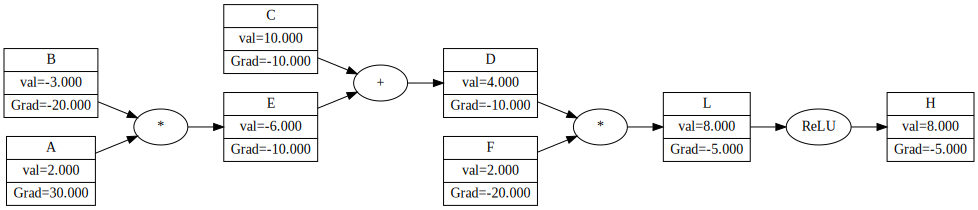

In [5]:
a = Value(2.0, "A")
b = Value(-3.0, "B")
c = Value(10.0, "C")
e = a * b; e.label = "E"
d = e + c; d.label = "D"
f = Value(2.0, "F")
g = d * f; g.label = "L";
h = g.relu(); h.label= "H"
k = Value(-5); k.label = "K"
m = h * k; m.label = "M"



print(a)
print(b)
print(c)
print(e)
print(d)
print(f)
print(g)
print(h)
print(k)
print(m)
m.backprop()
draw(h)


['B', 'A', '_', 'C', '_', '_', 'D', '_', 'F']


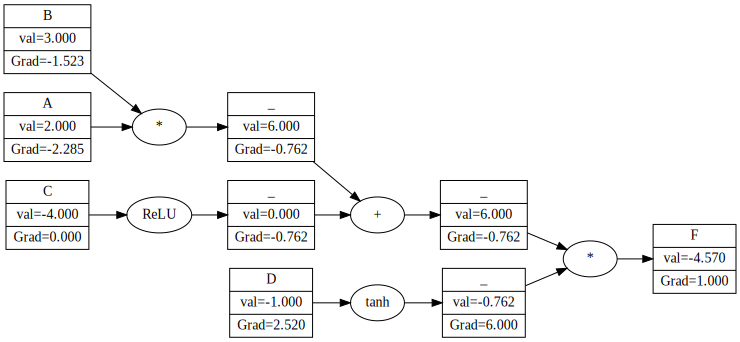

In [6]:
a = Value(2.0, "A")
b = Value(3.0, "B")
c = Value(-4.0, "C")
d = Value(-1.0, "D")
f = (a * b + c.relu()) * d.tanh(); f.label= "F"

f.backprop()
draw(f)

In [31]:
import random

class Module:
    def zero_grad(self):
        for param in self.params():
            param = 0

    def params(self):
        return []

class Neuron(Module):

    def __init__(self, ninputs, nonlin=True):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(ninputs)]
        self.b = Value(0)
        self.nonlin = nonlin

    def params(self):
        return self.w + [self.b]

    def __call__(self, inputs):
        activation = sum([wk * xk for wk,xk in zip(self.w, inputs)], self.b)
        return activation.relu() if self.nonlin else activation


    def __repr__(self):
        wv = [w.val for w in self.params()]
        return ("Non" if self.nonlin else "") + f"LinearNeuron({wv})"


class Layer(Module):

    def __init__(self, ninputs, noutputs, nonlin=True):
        self.neurons = [Neuron(ninputs, nonlin) for _ in range(noutputs)]

    def __call__(self, inputs):
        return [n(inputs) for n in self.neurons]

    def params(self):
        res = []
        for n in self.neurons: res.extend(n.params())
        return res

    def __repr__(self):
        newline = '\n'
        return f"Layer of [{newline}{(',' + newline).join(str(n) for n in self.neurons)}{newline}]"



class MLP(Module):

    def __init__(self, ninputs, layerlist, nonlin=True):
        nonlist = [nonlin] * len(layerlist); nonlist[-1] = False
        dim = [ninputs] + layerlist
        self.layers = [Layer(dim[k], dim[k + 1], nonlist[k]) for k in range(len(layerlist))]

    def __call__(self, inputs):
        x = inputs
        for layer in self.layers: x = layer(x)
        return x

    def params(self):
        res = []
        for cl in self.layers: res.extend(cl.params())
        return res

    def __repr__(self):
        newline = '\n'
        return f"MLP of [{newline}{(', ' + newline).join(str(layer) for layer in self.layers)}]"


In [32]:
n = Neuron(2, False)
nl = Layer(2, 3, True)
nmlp = MLP(2, [3, 4, 1], True)

print(nmlp)

MLP of [
Layer of [
NonLinearNeuron([-0.4199349873895355, -0.1787132497109336, 0]),
NonLinearNeuron([0.9777217689165167, 0.1628427620023487, 0]),
NonLinearNeuron([0.7142969774253756, 0.16338665760801807, 0])
], 
Layer of [
NonLinearNeuron([-0.7266869334862947, 0.09413941245671653, 0.48471209550918837, 0]),
NonLinearNeuron([-0.05133146613009232, -0.6263541392323566, 0.36840971784651333, 0]),
NonLinearNeuron([-0.9002289386475701, 0.29153440288571497, 0.40096521041804856, 0]),
NonLinearNeuron([0.5620992672155622, 0.001617755978585711, 0.9636515829052867, 0])
], 
Layer of [
LinearNeuron([0.07271972220504641, 0.8045153167063313, -0.20506385912594438, 0.3554055291230227, 0])
]]
